In [1]:
import json
import pickle 
import numpy as np
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import scipy as sp
from scipy import optimize


In [2]:
%cd ~/Documents/Lab/Informatics/Dropseq/

/Users/atambe/Documents/Lab/Informatics/dropseq


In [5]:
run_outputs = './macosko_test/run_outputs.json'
with open(run_outputs, 'r') as inf:
    fnames = json.load(inf)

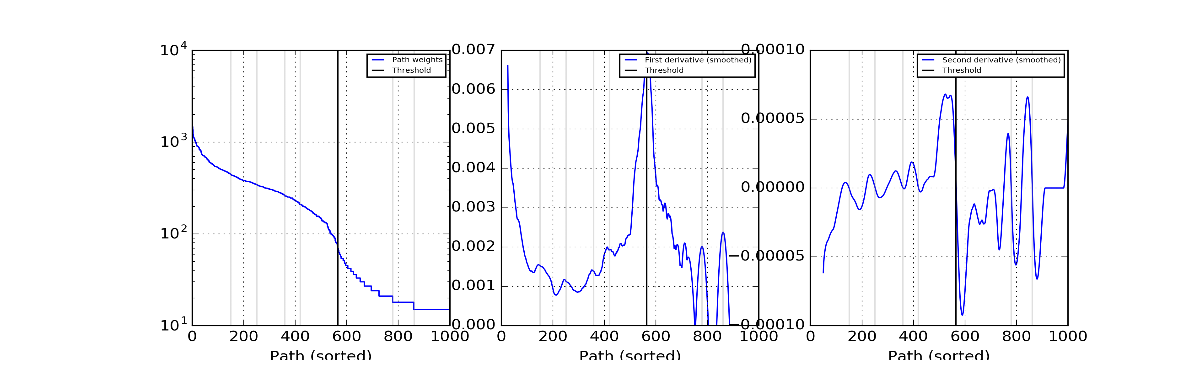

In [13]:
"""
Display number of cells etc
"""
import matplotlib.image as mpimg

num_cells_plotted = fnames['paths_plot']
img = mpimg.imread(num_cells_plotted)
fig, ax = plt.subplots(figsize = (12, 4))
ax.imshow(img, aspect = 'auto')
ax.axis('off')
plt.tight_layout()



In [4]:
"""
weights hist
"""
def read_paths_data(paths_file):
    """
    Args
    paths_file (string)
    Returns
    paths (list): list of tuples (int weight, set kmers)

    """
    paths = []#list of tuples, (int weight, set kmers)
    with open(paths_file) as inf:
        for line in inf:
            data = line.rstrip().split('\t')
            seq = data[0]
            weight = int(data[1])
            paths.append((seq, weight, data[2], data[3]))
    return paths


In [5]:
print(fnames.keys())
top_paths = read_paths_data(fnames['thresholded_paths'])

dict_keys(['log', 'tcc', 'kallisto', 'all_paths', 'split', 'merged_paths', 'paths_plot', 'thresholded_paths', 'run_outputs', 'slopes'])


In [6]:
l1_dist = np.load(fnames['tcc']['l1_dist'])
nonzero_eq = np.load(fnames['tcc']['nonzero_eq'])
tcc_norm_t = np.load(fnames['tcc']['tcc_norm_t'])

with open(fnames['tcc']['tcc_coo'], 'rb') as f:
    tcc_coo = pickle.load(f)
with open(fnames['tcc']['tcc_csr'], 'rb') as f:
    tcc_csr = pickle.load(f)

tcc = tcc_csr.todense()

In [7]:
#this is slow
ec_file = fnames['kallisto']['equiv_classes']
ec_dict = {}

with open(ec_file, 'r') as inf:
    for line in inf:
        tup = line.strip().split('\t')
        num = int(tup[0])
        lst = [int(i) for i in tup[1].split(',')]
        ec_dict[num] = lst

In [8]:
num_cells = np.shape(tcc_coo)[1]
print("Number of cells = %i" % num_cells)
print("Number of nonzero equiv classes = %i" % np.shape(tcc_coo)[0])

Number of cells = 590
Number of nonzero equiv classes = 79102


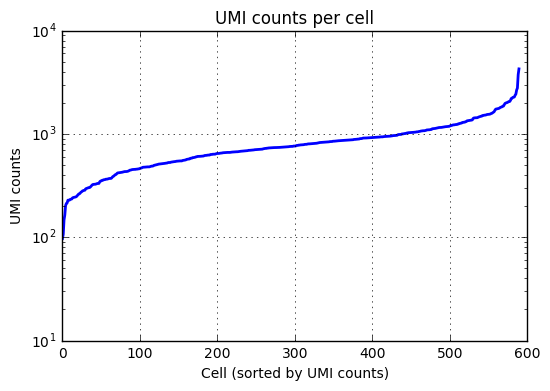

In [9]:

"""
Cell abundance distr
"""

def plot_umi_per_cell():
    fig, ax1 = plt.subplots()
    ax1.plot(sorted(umis_per_cell), 'b-',linewidth=2.0)
    ax1.set_title('UMI counts per cell')
    ax1.set_xlabel('Cell (sorted by UMI counts)')
    ax1.set_ylabel('UMI counts')
    ax1.set_yscale("log", nonposy='clip')
    # ax1.set_xscale("log", nonposy='clip')
    ax1.grid(True)

umis_per_cell = np.array(tcc.sum(axis=0))[0,:]

plot_umi_per_cell()   
    

In [10]:
"""
Barnyard
"""

#read combined transcriptome
#find where transcripts change from human to mouse
#record that line number

def get_human_index():
    import gzip
    combined_transcriptome = './reference/Mus_musculus.GRCm38.' \
        + 'rel79_Homo_sapiens.GRCh38.rel79.cdna.mix.fa.gz'
    count = 0
    flag=0
    human_index = 0
    with gzip.open(combined_transcriptome) as f:
        for (i, line) in enumerate(f):
            line = line.decode('utf-8')
            if(line[0] == '>'):
                if line[:5] != ">ENSM" and flag == 0:
                    human_index = count
                    flag = 1
                count += 1
    return human_index

def assign_equiv_classes(human_index):
    human_ec =[]  # eq. classes that correspond only to human (contain only human transcripts)
    mouse_ec = [] # eq. classes that correspond only to mouse
    joint_ec =[]  # mixed eq. classes (both human and mouse transcripts)

    for ec in nonzero_eq:
        if all(i >= human_index for i in ec_dict[ec]):
            human_ec += [ec]
        elif all(i < human_index for i in ec_dict[ec]):
            mouse_ec += [ec]
        else:
            joint_ec += [ec]
    return (human_ec, mouse_ec, joint_ec)

def get_equiv_class_idx(human_ec, mouse_ec, joint_ec):
    hum_ec_idx=[]
    mouse_ec_idx= []
    joint_ec_idx= []

    sethuman=set(human_ec)
    setmouse=set(mouse_ec)

    for i,ec in enumerate(nonzero_eq):
        if ec in sethuman: 
            hum_ec_idx+=[i]
        elif ec in setmouse:
            mouse_ec_idx+=[i]
        else: joint_ec_idx+=[i]

    return(hum_ec_idx, mouse_ec_idx, joint_ec_idx)

def plot_barnyard():
    human_index = get_human_index()
    (human_ec, mouse_ec, joint_ec) = assign_equiv_classes(human_index)
    (hum_ec_idx, mouse_ec_idx, joint_ec_idx) = get_equiv_class_idx(human_ec, mouse_ec, joint_ec)
    
    mouse_ = np.array(tcc[mouse_ec_idx,:].sum(axis=0))[0,:]
    human_ = np.array(tcc[hum_ec_idx,:].sum(axis=0))[0,:]
    
    fig, ax_arr = plt.subplots(nrows= 1, ncols = 2, figsize=(8,4))
    for ax in ax_arr:
        ax.set_xlabel('Mouse UMI counts')
        ax.set_ylabel('Human UMI counts')
        ax.set_title('Barnyard plot, human / mouse')
        #ax.set_xscale('log')
        #ax.set_yscale('log')

        for cell in range(len(human_)):
            ax.scatter(mouse_[cell],human_[cell],c='red',s=16,edgecolors='black',
                                lw = 0.5, alpha=0.1,marker='o')

    #ax_arr[0].set_xlim([-1000,5000])
    #ax_arr[0].set_ylim([-1000,5000])       
    ax_arr[1].set_xscale('log')
    ax_arr[1].set_yscale('log')
    plt.tight_layout()
    

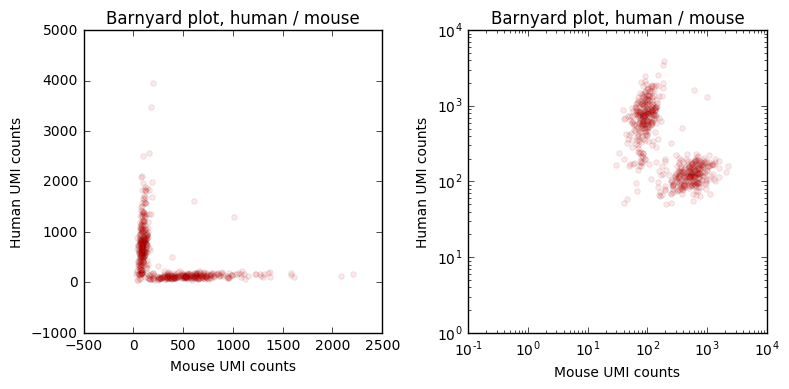

In [11]:
plot_barnyard()

In [12]:
"""
tSNE clustering
"""
from sklearn import cluster,manifold

def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',
                                     preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

def spectral(k,D):
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

def tSNE_pairwise(D):
    tsne = manifold.TSNE(
        n_components=2,
        random_state=213,
        metric='precomputed',
        n_iter=2000,
        verbose=1
    )
    X_tsne = tsne.fit_transform(D);
    return X_tsne

def stain_plot(X,labels,stain,title,nc=2):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), 
             int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        
        if label in stain: 
            ax.scatter(X[ind,0],X[ind,1],c= 'r',s=146,
                        lw = 0.5, alpha=1,marker='*',label=label)
        else:
            ax.scatter(X[ind,0],X[ind,1],c=color[i],s=36,
                        lw = 0.5,label=label)        
        i+=1   
    ax.set_title(title)
    ax.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=nc)
    ax.axis('off')


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.128701
[t-SNE] Error after 100 iterations with early exaggeration: 1.086370
[t-SNE] Error after 175 iterations: 1.097519


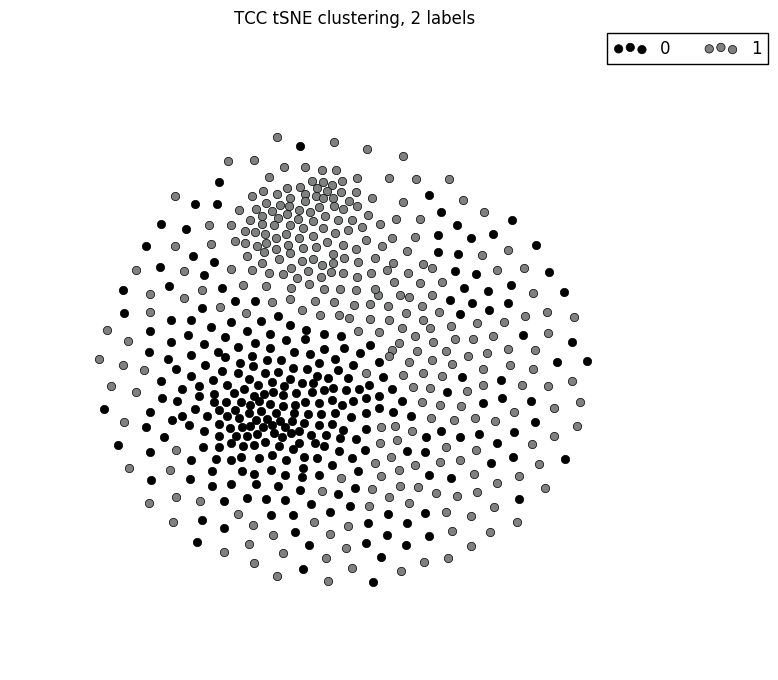

In [13]:
tsne = tSNE_pairwise(l1_dist)
labels_2 = spectral(2, l1_dist.max() - l1_dist)
stain_plot(tsne,labels_2,[], 'TCC tSNE clustering, 2 labels')